# Evaluating the Impact of Practical Models on Algorithm Performance

In this example we use real-world operational data to evaluate (through simulations) how the Adaptive Scheduling Algorithm and other baseline algorithms handle the practical challenges in real charging systems. To do this, we consider two practical objectives, charging users quickly in highly constrained systems, and maximizing operating profits.

In [1]:
from datetime import datetime
import pytz
from copy import deepcopy
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import json
import os

from acnportal import acnsim, algorithms
from acnportal.acnsim import analysis
from acnportal.signals.tariffs import TimeOfUseTariff
from adacharge import *

# Experiment Setup

In [2]:
API_KEY = 'DEMO_TOKEN'
TIMEZONE = pytz.timezone('America/Los_Angeles')
SITE = 'caltech'
PERIOD = 5  # minutes
VOLTAGE = 208  # volts
KW_TO_AMPS = 1000 / 208
KWH_TO_AMP_PERIODS = KW_TO_AMPS * (60 / 5)
MAX_LEN = 144
FORCE_FEASIBLE = True
EVENTS_DIR = 'events/'
VERBOSE = True

In [3]:
def get_events(start, end, ideal_battery, force_feasible, max_len):
    """ Gather Events from ACN-Data with a local cache. """
    event_name = f'{start}:{end}:{ideal_battery}:{force_feasible}:' \
                 f'{max_len}'
    path = os.path.join(EVENTS_DIR, event_name + '.json')
    if os.path.exists(path):
        with open(path, 'r') as f:
            return acnsim.EventQueue.from_json(f)
    start_time = TIMEZONE.localize(datetime.strptime(start, '%m-%d-%Y'))
    end_time = TIMEZONE.localize(datetime.strptime(end, '%m-%d-%Y'))
    default_battery_power = 6.656
    if ideal_battery:
        battery_params=None
    else:
        battery_params={'type': acnsim.Linear2StageBattery,
                        'capacity_fn': acnsim.models.battery.batt_cap_fn}
    events = acnsim.acndata_events.generate_events(API_KEY, SITE,
                                                   start_time, end_time,
                                                   PERIOD, VOLTAGE,
                                                   default_battery_power,
                                                   force_feasible=force_feasible,
                                                   max_len=max_len,
                                                   battery_params=battery_params)
    if not os.path.exists(EVENTS_DIR):
        os.mkdir(EVENTS_DIR)
    with open(path, 'w') as f:
        events.to_json(f)
    return events

In [4]:
class Experiment:
    """ Wrapper for ACN-Sim Experiments including caching serialized experiment to disk. """
    def __init__(self, sim):
        self.sim = sim

    def calc_metrics(self):
        """ Calculate metrics from simulation. """
        metrics = {
            'proportion_delivered': analysis.proportion_of_energy_delivered(
                self.sim) * 100,
            'demands_fully_met': analysis.proportion_of_demands_met(
                self.sim) * 100,
            'peak_current': self.sim.peak,
            'demand_charge': analysis.demand_charge(self.sim),
            'energy_cost': analysis.energy_cost(self.sim),
            'total_energy_delivered': analysis.total_energy_delivered(self.sim),
            'total_energy_requested': analysis.total_energy_requested(self.sim)
        }
        return metrics

    def log_local_file(self, path):
        """ Write simulation, metrics and solver statistics to disk. """
        self.sim.to_json(path + 'sim.json')
        with open(path + 'metrics.json', 'w') as outfile:
            json.dump(self.calc_metrics(), outfile)
        with open(path + 'solve_stats.json', 'w') as outfile:
            json.dump(self.sim.scheduler.solve_stats, outfile)

    def run_and_store(self, path):
        """ Run experiment and store results. """
        print(f'Starting - {path}')
        if os.path.exists(path + 'sim.json'):
            print(f'Already Run - {path}...')
            return
        try:
            self.sim.run()
            if not os.path.exists(path):
                os.makedirs(path)
            self.log_local_file(path)
            print(f'Done - {path}')
        except Exception as e:
            print(f'Failed - {path}')
            print(e)

In [5]:
def configure_sim(
    alg, 
    cap, 
    start, 
    events, 
    basic_evse=True,
    estimate_max_rate=False, 
    uninterrupted_charging=False,
    quantized=False,
    allow_overcharging=False,
    tariff_name=None,
    offline=False
):
    """ Configure simulation. """
    start_time = TIMEZONE.localize(datetime.strptime(start, '%m-%d-%Y'))
        
    if estimate_max_rate:
        alg.max_rate_estimator = algorithms.SimpleRampdown()
        alg.estimate_max_rate = True
    alg.uninterrupted_charging = uninterrupted_charging
    alg.allow_overcharging = allow_overcharging

    # Some algorithms support a quantized option
    if quantized:
        try:
            alg.quantize = True
        except:
            pass
        try:
            alg.reallocate = True
        except:
            pass

    cn = acnsim.sites.caltech_acn(voltage=VOLTAGE,
                                  transformer_cap=cap,
                                  basic_evse=basic_evse)
    if tariff_name is not None:
        signals = {'tariff': TimeOfUseTariff(tariff_name)}
    else:
        signals = {}
    sim = acnsim.Simulator(cn, alg, events, start_time, signals=signals,
                           period=PERIOD, verbose=False)
    
    if offline:
        alg.register_events(events)
        alg.solve()
    
    return sim

In [6]:
# def optimal_experiment(alg, cap, start, events, tariff_name=None):
#     """ Run experiment using perfect offline information."""
#     start_time = TIMEZONE.localize(datetime.strptime(start, '%m-%d-%Y'))
#     alg.register_events(events)
#     cn = acnsim.sites.caltech_acn(voltage=VOLTAGE,
#                                   transformer_cap=cap,
#                                   basic_evse=True)
#     if tariff_name is not None:
#         signals = {'tariff': TimeOfUseTariff(tariff_name)}
#     else:
#         signals = {}
#     sim = acnsim.Simulator(cn, alg, events, start_time, signals=signals,
#                            period=PERIOD, verbose=VERBOSE)
#     alg.solve()
#     return sim

## Experiment Configurations

In [7]:
start = '9-1-2018'
end = '10-1-2018'
tariff_name = 'sce_tou_ev_4_march_2019'
revenue = 0.3
# Scenario I is the offline optimal.
scenarios = {
                'II': {'ideal_battery': True,
                      'estimate_max_rate': False,
                      'uninterrupted_charging': False,
                      'quantized': False,
                      'basic_evse': True
                },
                'III': {'ideal_battery': True,
                       'estimate_max_rate': False,
                       'uninterrupted_charging': True,
                       'quantized': True,
                       'basic_evse': False
                },
                'IV': {'ideal_battery': False,
                        'estimate_max_rate': True,
                        'uninterrupted_charging': False,
                        'quantized': False,
                        'basic_evse': True
                },
                'V': {'ideal_battery': False,
                       'estimate_max_rate': True,
                       'uninterrupted_charging': True,
                       'quantized': True,
                       'basic_evse': False
                },
}

## Energy delivered with constrained infrastructure

**Note that these experiments can take a long time to run.**


In [8]:
energy_del_base_dir = 'results/infrastructure_utilization_results2'

### Running Experiments

We first consider the objective of maximizing total energy delivered when infrastructure is oversubscribed. This is a common use case when electricity prices are static or when user satisfaction is the primary concern. To optimize for this operator objective, we use the Adaptive Scheduling Algorithm (ASA) with utility function

\begin{equation*}
U^\mathrm{QC}(r) := u^{QC}(r) + 10^{-12}u^{ES}(r)
\end{equation*}

Here $U^{QC}$ encourages the system to deliver energy as quickly as possible, which helps free capacity for future arrivals. We include the regularizer $u^{ES}(r)$ to promote equal sharing between similar EVs and force a unique solution. We refer to this algorithm as ASA-QC. We set the weight of the $u^{ES}(r)$ term to be small enough to ensure a strict hierarchy of terms in the objective.

To control congestion in the system, we vary the capacity of transformer $t_1$ between 20 and 150 kW. For reference, the actual transformer in our system is 150 kW, and a conventional system of this size would require 362 kW of capacity. We then measure the percent of the total energy demand met using ASA-QC as well as three baseline scheduling algorithms;  least laxity first (LLF), earliest deadline first (EDF), and round-robin (RR), as implemented in ACN-Sim and are described in (Lee, ACN-Sim, 2020). These baseline algorithms are very common in the deadline scheduling literature and have been applied previously to the EV charging domain (Xu, Dynamic, 2016)(Zeballos, Proportional, 2019}. In addition, the round robin algorithm is a generalization of the equal sharing algorithm used by many charging providers today.

In [9]:
ALGS = dict()
ALGS['LLF'] = algorithms.SortedSchedulingAlgo(algorithms.least_laxity_first)
ALGS['EDF'] = algorithms.SortedSchedulingAlgo(algorithms.earliest_deadline_first)
ALGS['RR'] = algorithms.RoundRobin(algorithms.first_come_first_served, continuous_inc=1)

quick_charge_obj = [
    ObjectiveComponent(quick_charge),
    ObjectiveComponent(equal_share, 1e-12)
]
ALGS['ASA-QC'] = AdaptiveSchedulingAlgorithm(quick_charge_obj,
                                             solver='MOSEK',
                                             max_recompute=1)

In [ ]:
# Online Algorithms
caps = list(range(20, 81, 10)) + [150]
for scenario_id, scenario in scenarios.items():
    for cap in caps:
        for alg in ['ASA-QC', 'LLF', 'EDF', 'RR']:
            output_dir = f'{energy_del_base_dir}/{start}:{end}/{scenario_id}/{cap}/{alg}/'
            events = get_events(start, end, scenario['ideal_battery'], FORCE_FEASIBLE, MAX_LEN)

            sim = configure_sim(
                cap=cap,
                alg=deepcopy(ALGS[alg]),
                start=start,
                events=events,
                basic_evse=scenario['basic_evse'],
                estimate_max_rate=scenario['estimate_max_rate'],
                uninterrupted_charging=scenario['uninterrupted_charging'],
                quantized=scenario['quantized'],
                tariff_name=tariff_name
            )
            ex = Experiment(sim)
            ex.run_and_store(output_dir)

Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/20/ASA-QC/
Already Run - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/20/ASA-QC/...
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/20/LLF/
Already Run - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/20/LLF/...
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/20/EDF/
Already Run - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/20/EDF/...
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/20/RR/
Already Run - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/20/RR/...
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/30/ASA-QC/
Already Run - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/30/ASA-QC/...
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/30/LLF/
Already Run - results/inf

/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:387: UserWarning: Not serializing signals as value typesare not natively JSON serializable.
  warnings.warn(


Done - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/50/ASA-QC/
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/50/LLF/
Already Run - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/50/LLF/...
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/50/EDF/
Already Run - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/50/EDF/...
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/50/RR/
Already Run - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/50/RR/...
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/60/ASA-QC/
Done - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/60/ASA-QC/
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/60/LLF/
Already Run - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/II/60/LLF/...
Starting - results/infrastructure_utilizat

/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 458. Max violation is 0.04935961367631592 A on Primary A at time index 16.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 459. Max violation is 0.04935961367631592 A on Primary A at time index 15.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 460. Max violation is 0.04935961367631592 A on Primary A at time index 14.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 461. Max violation is 0.04935961367631592 A on Primary A at time index 13.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 46

Done - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/III/70/ASA-QC/
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/III/70/LLF/
Already Run - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/III/70/LLF/...
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/III/70/EDF/
Already Run - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/III/70/EDF/...
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/III/70/RR/
Already Run - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/III/70/RR/...
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/III/80/ASA-QC/


/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 4775. Max violation is 0.000887619160650388 A on Primary B at time index 0.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 4776. Max violation is 0.000887619160650388 A on Primary B at time index 0.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 6736. Max violation is 0.004782816539261603 A on Primary B at time index 0.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 6737. Max violation is 0.004782816539261603 A on Primary B at time index 0.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteratio

Done - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/III/80/ASA-QC/
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/III/80/LLF/
Already Run - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/III/80/LLF/...
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/III/80/EDF/
Already Run - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/III/80/EDF/...
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/III/80/RR/
Already Run - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/III/80/RR/...
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/III/150/ASA-QC/
Already Run - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/III/150/ASA-QC/...
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/III/150/LLF/
Already Run - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/III/150/LLF/...
Starting - result

/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 159. Max violation is 0.005211976800843843 A on Secondary B at time index 42.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 495. Max violation is 0.005211976800843843 A on Secondary B at time index 30.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 496. Max violation is 0.005211976800843843 A on Secondary B at time index 30.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 777. Max violation is 0.014210402243662656 A on Secondary A at time index 24.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at 

Done - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/20/ASA-QC/
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/20/LLF/
Done - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/20/LLF/
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/20/EDF/
Done - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/20/EDF/
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/20/RR/
Done - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/20/RR/
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/30/ASA-QC/


/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 706. Max violation is 0.021320603365495572 A on Secondary B at time index 0.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 1431. Max violation is 0.021320603365495572 A on Secondary B at time index 0.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 1432. Max violation is 0.021320603365495572 A on Secondary B at time index 0.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 1433. Max violation is 0.021320603365495572 A on Secondary B at time index 0.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at i

Done - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/30/ASA-QC/
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/30/LLF/
Done - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/30/LLF/
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/30/EDF/
Done - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/30/EDF/
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/30/RR/
Done - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/30/RR/
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/40/ASA-QC/


/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 178. Max violation is 0.028430804487314276 A on Secondary B at time index 0.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 179. Max violation is 0.028430804487314276 A on Secondary B at time index 0.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 180. Max violation is 0.028430804487314276 A on Secondary B at time index 0.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 181. Max violation is 0.028430804487314276 A on Secondary B at time index 0.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iter

Done - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/40/ASA-QC/
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/40/LLF/
Done - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/40/LLF/
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/40/EDF/
Done - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/40/EDF/
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/40/RR/
Done - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/40/RR/
Starting - results/infrastructure_utilization_results2/9-1-2018:10-1-2018/V/50/ASA-QC/


 We also consider the maximum energy that could be delivered by solving our optimization problem with objective

\begin{equation*}
    U^\mathrm{EM\_OFF}(r) :=  \sum_{\substack{t \in \mathcal{T}\\i \in \mathcal{V}}} r_i(t)
\end{equation*}

\noindent and perfect foreknowledge of future arrivals, i.e. $\mathcal{V}$ includes all EVs, not just those present at time $k$. We also modify the constraints so that EVs cannot charge before their arrival time. We refer to this as the *Optimal* solution.

In [74]:
# Offline Optimal
optimal_obj = [ObjectiveComponent(total_energy)]
optimal_alg = AdaptiveChargingAlgorithmOffline(optimal_obj, solver='MOSEK')
for cap in caps:
    output_dir = f'{energy_del_base_dir}/{start}:{end}/I/{cap}/Optimal/'
    events = get_events(start, end, True, FORCE_FEASIBLE, MAX_LEN)

    sim = configure_sim(
        cap=cap,
        alg=deepcopy(ALGS[alg]),
        start=start,
        events=events,
        basic_evse=True,
        estimate_max_rate=False,
        uninterrupted_charging=False,
        quantized=False,
        tariff_name=tariff_name
    )
    ex = Experiment(sim)
    ex.run_and_store(output_dir)

Starting - results/infrastructure_utilization_results/9-1-2018:10-1-2018/I/20/Optimal/
Already Run - results/infrastructure_utilization_results/9-1-2018:10-1-2018/I/20/Optimal/...
Starting - results/infrastructure_utilization_results/9-1-2018:10-1-2018/I/30/Optimal/
Already Run - results/infrastructure_utilization_results/9-1-2018:10-1-2018/I/30/Optimal/...
Starting - results/infrastructure_utilization_results/9-1-2018:10-1-2018/I/40/Optimal/
Already Run - results/infrastructure_utilization_results/9-1-2018:10-1-2018/I/40/Optimal/...
Starting - results/infrastructure_utilization_results/9-1-2018:10-1-2018/I/50/Optimal/
Already Run - results/infrastructure_utilization_results/9-1-2018:10-1-2018/I/50/Optimal/...
Starting - results/infrastructure_utilization_results/9-1-2018:10-1-2018/I/60/Optimal/
Already Run - results/infrastructure_utilization_results/9-1-2018:10-1-2018/I/60/Optimal/...
Starting - results/infrastructure_utilization_results/9-1-2018:10-1-2018/I/70/Optimal/
Already Run -

### Analysis

Results from this experiment are shown below, from which we observe the following trends. 

1. In scenario II, ASA-QC performs near optimally (within 0.4\%), and significantly outperforms the baselines (by as much as 14.1\% compared to EDF with 30 kW capacity).
2. In almost all cases, ASA-QC performs better than baselines, especially so in highly congested settings.
3. Non-ideal EVSEs (scenarios III and V) have a large negative effect on ASA-QC, which we attribute to rounding of the optimal pilots and restriction of the feasible set.
4. Surprisingly, non-ideal EVSEs increase the performance of LLF and EDF for transformer capacities $<$60 kW. This may be because the minimum current constraint leads to better phase balancing.
5. Non-ideal batteries (scenarios IV and V) have relatively small effect on the performance of ASA-QC compared to baselines, indicating the robustness of the algorithm.

To understand why ASA-QC performs so much better than the baselines, especially in scenario II, we must consider what information each algorithm uses. RR uses no information aside from which EVs are currently present, and as such, performs the worst. Likewise, EDF uses only information about departure time, while LLF also makes use of the EVs energy demand. Only ASA-QC actively optimizes over infrastructure constraints, allowing it to better balance phases (increasing throughput) and prioritize EVs including current and anticipated congestion. A key feature of the ASA framework is its ability to account for all available information cleanly.\footnote{When even more information is available, i.e., a model of the vehicle's battery or predictions of future EV arrivals, this information can also be accounted for in the constraint set $\mathcal{R}$ and objective $U(r)$. However, these formulations are outside the scope of this paper.

In [75]:
def get_metric(results_dir, config, metric_name):
    path = os.path.join(results_dir, f"{config['start']}:{config['end']}", config['scenario'],
               str(config['cap']), config['alg'], 'metrics.json')
    if not os.path.exists(path):
        return float('nan')
    with open(path) as f:
        metrics = json.load(f)
    if metric_name is None:
        return metrics
    else:   
        return metrics[metric_name]

def get_solve_stats(results_dir, config):
    path = os.path.join(results_dir, f"{config['start']}:{config['end']}", config['scenario'],
               str(config['cap']), config['alg'], 'solve_stats.json')
    if not os.path.exists(path):
        return float('nan')
    with open(path) as f:
        return json.load(f)

def get_sim(results_dir, config):
    path = os.path.join(results_dir, f"{config['start']}:{config['end']}", config['scenario'],
               str(config['cap']), config['alg'], 'sim.json')
    if not os.path.exists(path):
        return None
    with open(path) as f:
        try:
            return acnsim.Simulator.from_json(f)
        except:
            print(path)

In [76]:
start = '9-1-2018'
end = '10-1-2018'
caps = list(range(20, 81, 10)) + [150]
algs = ['ASA-QC', 'LLF', 'EDF', 'RR']
scenario_order = ['II', 'III', 'IV', 'V']
percent_del = dict()

percent_del['Optimal'] = np.full((1, len(caps)), np.nan)
for col, cap in enumerate(caps):
    config = {'scenario': 'I', 'start': start, 'end': end, 'cap': cap, 'alg': 'Optimal'}
    percent_del['Optimal'][0, col] = get_metric(f'{energy_del_base_dir}/', config, 'proportion_delivered')

for scenario in scenario_order:
    percent_del[scenario] = np.full((len(algs), len(caps)), np.nan)
    for row, alg in enumerate(algs):
        for col, cap in enumerate(caps):
            config = {'scenario': scenario, 'start': start, 'end': end, 'cap': cap, 'alg': alg}
            percent_del[scenario][row, col] = get_metric(f'{energy_del_base_dir}/', config, 'proportion_delivered')

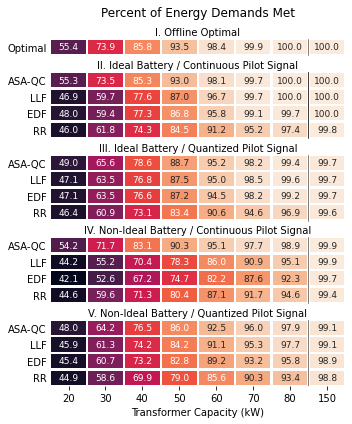

In [77]:
fig, ax = plt.subplots()
ax.set_title("Percent of Energy Demands Met")


fig.set_size_inches(5, 6)
labels = ['', 'Optimal',
          '', 'ASA-QC', 'LLF', 'EDF', 'RR',
          '', 'ASA-QC', 'LLF', 'EDF', 'RR',
          '', 'ASA-QC', 'LLF', 'EDF', 'RR',
          '', 'ASA-QC', 'LLF', 'EDF', 'RR']

spacer = np.full((1, len(caps)), np.nan)
stack = [spacer]
stack.append(percent_del['Optimal'])
for scenario in scenarios:
    stack.append(spacer)
    stack.append(percent_del[scenario])
heatmap = np.vstack(stack)


sns.heatmap(heatmap, annot=True, fmt='.1f', linewidth=1.5, ax=ax,
            cbar=False, annot_kws= {'fontsize':9}, yticklabels=labels, xticklabels=caps)
title_style = {'horizontalalignment': 'center', 'verticalalignment': 'center', 'fontsize': 10}
vert_offset = 0.6
ax.text(4, 0 + vert_offset, 'I. Offline Optimal', **title_style)
ax.text(4, 2 + vert_offset, 'II. Ideal Battery / Continuous Pilot Signal', **title_style)
ax.text(4, 7 + vert_offset, 'III. Ideal Battery / Quantized Pilot Signal', **title_style)
ax.text(4, 12 + vert_offset, 'IV. Non-Ideal Battery / Continuous Pilot Signal', **title_style)
ax.text(4, 17 + vert_offset, 'V. Non-Ideal Battery / Quantized Pilot Signal', **title_style)
ax.set_xlabel('Transformer Capacity (kW)')
ax.axvline(6.99, 21/22, 20/22, color='k', linewidth=0.5)
ax.axvline(6.99, 19/22, 15/22, color='k', linewidth=0.5)
ax.axvline(6.99, 19/22, 15/22, color='k', linewidth=0.5)
ax.axvline(6.99, 14/22, 10/22, color='k', linewidth=0.5)
ax.axvline(6.99, 9/22, 5/22, color='k', linewidth=0.5)
ax.axvline(6.99, 4/22, 0/22, color='k', linewidth=0.5)

ax.tick_params(axis=u'y', which=u'both',length=0)
fig.tight_layout();

In [78]:
fig.savefig('figures/infrastructure_heatmap.pdf', dpi=150)

In [79]:
start = '9-1-2018'
end = '10-1-2018'
caps = list(range(20, 81, 10)) + [150]
scenario_order = ['II', 'III', 'IV', 'V']
algs = ['ASA-QC', 'LLF', 'EDF', 'RR']
for scenario in scenario_order:
    avg_solve_time[scenario] = np.full((len(algs), len(caps)), np.nan)
    for row, alg in enumerate(algs):
        for col, cap in enumerate(caps):
            config = {'scenario': scenario, 'start': start, 'end': end,
                      'cap': cap, 'alg': alg}
            try:
                stats = pd.DataFrame(get_solve_stats(f'{energy_del_base_dir}/', config))
                stats = stats[stats['active_sessions'] > 25]
                avg_solve_time[scenario][row, col] = stats['solve_time'].mean()
            except:
                pass

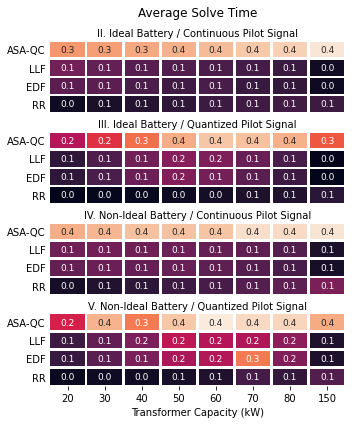

In [80]:
fig, ax = plt.subplots()
ax.set_title("Average Solve Time")
fig.set_size_inches(5, 6)
labels = ['', 'ASA-QC', 'LLF', 'EDF', 'RR',
          '', 'ASA-QC', 'LLF', 'EDF', 'RR',
          '', 'ASA-QC', 'LLF', 'EDF', 'RR',
          '', 'ASA-QC', 'LLF', 'EDF', 'RR']

stack = []
spacer = np.full((1, len(caps)), np.nan)
for scenario in scenarios:
    stack.append(spacer)
    stack.append(avg_solve_time[scenario])
heatmap = np.vstack(stack)


sns.heatmap(heatmap, annot=True, fmt='.1f', linewidth=1.5, ax=ax,
            cbar=False, annot_kws= {'fontsize':9}, yticklabels=labels, xticklabels=caps)
title_style = {'horizontalalignment': 'center', 'verticalalignment': 'center', 'fontsize': 10}
vert_offset = 0.6
ax.text(4, 0 + vert_offset, 'II. Ideal Battery / Continuous Pilot Signal', **title_style)
ax.text(4, 5 + vert_offset, 'III. Ideal Battery / Quantized Pilot Signal', **title_style)
ax.text(4, 10 + vert_offset, 'IV. Non-Ideal Battery / Continuous Pilot Signal', **title_style)
ax.text(4, 15 + vert_offset, 'V. Non-Ideal Battery / Quantized Pilot Signal', **title_style)
ax.set_xlabel('Transformer Capacity (kW)')

ax.tick_params(axis=u'y', which=u'both',length=0)
fig.tight_layout();

## Profit maximization with TOU tariffs and demand charge


In [81]:
profit_max_base_dir = 'results/profit_max_results'

### Running Experiments

Next, we consider the case where a site host would like to minimize their operating costs. Within this case, we will consider the Southern California Edison TOU EV-4 tariff schedule for separately metered EV charging systems between 20-500~kW. In each case, we assume that the charging system operator has a fixed revenue of \$0.30\/kWh and only delivers energy when their marginal cost is less than this revenue. 

In order to maximize profit, we use the objective:

\begin{equation*}
    U^\mathrm{PM} := u^{EC} + u^{DC} + 10^{-6}u^{QC} + 10^{ -12}u^{ES}
\end{equation*}

\noindent We denote the ASA algorithm with this objective ASA-PM.

The revenue term $\pi$ in $u^{EC}$ can have several interpretations. In the most straightforward case, $\pi$ is simply the price paid by users. However, $\pi$ can also include subsidies by employers, governments, automakers, or carbon credits through programs like the California Low-Carbon Fuel Standard (LCFS). For example, LCFS credits for EV charging have averaged between $0.13 - $0.16 / kWh in 2018-2019. In these cases, some energy demands might not be met if the marginal price of that energy exceeds $\pi$. This is especially important when demand charge is considered since the marginal cost can be extremely high if it causes a spike above the previous monthly peak. Alternatively, $\pi$ can be set to a very high value (greater than the maximum marginal cost of energy) and act as a non-completion penalty. When this is the case, the algorithm will attempt to minimize costs while meeting all energy demands (when it is feasible to do so).

In $u^{DC}$, $\hat{P}$ and $q'$ are tunable parameters. The demand charge proxy $\hat{P}$ controls the trade-off between energy costs and demand charges in the online problem. In this case, we use the heuristic proposed in (Lee, Pricing, 2020), $\hat{P} = P/(D_p - d)$, where $D_p$ is the number of days in the billing period, and $d$ is the index of the current day. We will consider one version of the algorithm without a peak hint, e.g. $q'=0$, and one where the peak hint is 75\% of the optimal peak calculated using data from the previous month. This percentage is chosen based on maximum historic month-to-month variability in the optimal peak (+11\%/-16\%).

We also include the quick charge objective as a regularizer, which encourages the scheduling algorithm to front-load charging within a TOU period. To ensure that this regularizer does not lead to a large increase in cost, we use a coefficient of $10^{-6}$. This results in an maximum increase in value of \$0.000058 / kWh, which is an three orders of magnitude lower than the minimum cost of energy.

We fix the transformer capacity to 150~kW and consider the previous baselines along with uncontrolled charging, which is the most common type of charging system today.

In [82]:
def days_remaining_scale_demand_charge(rates, infrastructure, interface,
                                       baseline_peak=0, **kwargs):
    """ Demand Charge Proxy which divideds the demand charge over the remaining days in the billing period. """
    day_index = interface.current_time // ((60 / interface.period) * 24)
    days_in_month = 30 #monthrange(year, month)[1]
    day_index = min(day_index, days_in_month - 1)
    scale = 1 / (days_in_month - day_index)
    dc = demand_charge(rates, infrastructure, interface, baseline_peak,
                       **kwargs)
    return scale * dc

ALGS = dict()
ALGS['Unctrl'] = algorithms.UncontrolledCharging()
ALGS['LLF'] = algorithms.SortedSchedulingAlgo(algorithms.least_laxity_first)
ALGS['EDF'] = algorithms.SortedSchedulingAlgo(algorithms.earliest_deadline_first)
ALGS['RR'] = algorithms.RoundRobin(algorithms.first_come_first_served, continuous_inc=1)

profit_max_obj_no_hint = [
    ObjectiveComponent(total_energy, revenue),
    ObjectiveComponent(tou_energy_cost),
    ObjectiveComponent(days_remaining_scale_demand_charge),
    ObjectiveComponent(quick_charge, 1e-6),
    ObjectiveComponent(equal_share, 1e-12)
]
ALGS['ASA-PM'] =  AdaptiveSchedulingAlgorithm(profit_max_obj_no_hint,
                                                          solver='MOSEK',
                                                          max_recompute=1)

profit_max_obj_w_hint = [
    ObjectiveComponent(total_energy, revenue),
    ObjectiveComponent(tou_energy_cost),
    # This peak estimate is taken from Aug 2018.
    ObjectiveComponent(days_remaining_scale_demand_charge, 1,
                       {'baseline_peak': 66.56 *.75}),
    ObjectiveComponent(quick_charge, 1e-6),
    ObjectiveComponent(equal_share, 1e-12)]
ALGS['ASA-PM-Hint'] = AdaptiveSchedulingAlgorithm(profit_max_obj_w_hint,
                                                     solver='MOSEK',
                                                     max_recompute=1)

In [83]:
# Online Algorithms
for scenario_id, scenario in scenarios.items():
    for alg in ALGS:
        output_dir = f'{profit_max_base_dir}/{start}:{end}/{tariff_name}/{revenue}/' \
                     f'{scenario_id}/{cap}/{alg}/'
        events = get_events(start, end, scenario['ideal_battery'],
                            FORCE_FEASIBLE, MAX_LEN)
        sim = configure_sim(
            cap=cap,
            alg=deepcopy(ALGS[alg]),
            start=start,
            events=events,
            basic_evse=scenario['basic_evse'],
            estimate_max_rate=scenario['estimate_max_rate'],
            uninterrupted_charging=scenario['uninterrupted_charging'],
            quantized=scenario['quantized'],
            tariff_name=tariff_name
        )
        ex = Experiment(sim)
        ex.run_and_store(output_dir)

Starting - results/profit_max_results/9-1-2018:10-1-2018/sce_tou_ev_4_march_2019/0.3/II/150/Unctrl/
Already Run - results/profit_max_results/9-1-2018:10-1-2018/sce_tou_ev_4_march_2019/0.3/II/150/Unctrl/...
Starting - results/profit_max_results/9-1-2018:10-1-2018/sce_tou_ev_4_march_2019/0.3/II/150/LLF/
Already Run - results/profit_max_results/9-1-2018:10-1-2018/sce_tou_ev_4_march_2019/0.3/II/150/LLF/...
Starting - results/profit_max_results/9-1-2018:10-1-2018/sce_tou_ev_4_march_2019/0.3/II/150/EDF/
Already Run - results/profit_max_results/9-1-2018:10-1-2018/sce_tou_ev_4_march_2019/0.3/II/150/EDF/...
Starting - results/profit_max_results/9-1-2018:10-1-2018/sce_tou_ev_4_march_2019/0.3/II/150/RR/
Already Run - results/profit_max_results/9-1-2018:10-1-2018/sce_tou_ev_4_march_2019/0.3/II/150/RR/...
Starting - results/profit_max_results/9-1-2018:10-1-2018/sce_tou_ev_4_march_2019/0.3/II/150/ASA-PM/
Already Run - results/profit_max_results/9-1-2018:10-1-2018/sce_tou_ev_4_march_2019/0.3/II/150/A

We also consider the optimal profit possible by solving an optimization with perfect foreknowledge of arrivals and objective:

\begin{equation*}
U^\mathrm{PM\_OFF} := u^{EC} + u^{DC}
\end{equation*}

with $\hat{P} = P$, $q'=0$.

In [84]:
# Offline Optimal
optimal_obj = [ObjectiveComponent(total_energy, revenue),
               ObjectiveComponent(tou_energy_cost),
               ObjectiveComponent(demand_charge)]
optimal_alg = AdaptiveChargingAlgorithmOffline(optimal_obj, solver='MOSEK')
output_dir = f'{profit_max_base_dir}/{start}:{end}/{tariff_name}/{revenue}/I/{cap}/Optimal/'
events = get_events(start, end, True, FORCE_FEASIBLE, MAX_LEN)
sim = configure_sim(alg=deepcopy(optimal_alg),
                    cap=cap,
                    start=start,
                    events=events,
                    tariff_name=tariff_name
)
ex = Experiment(sim)
ex.run_and_store(output_dir)

Starting - results/profit_max_results/9-1-2018:10-1-2018/sce_tou_ev_4_march_2019/0.3/I/150/Optimal/
Already Run - results/profit_max_results/9-1-2018:10-1-2018/sce_tou_ev_4_march_2019/0.3/I/150/Optimal/...


### Analysis

Results of the experiment are shown below, from which we observe:

1. Profits from both ASA-PM and ASA-PM w/ Hint, are within 3.6\% and 1.9\% of the optimal respectively, and far exceed the profits of all baseline algorithms.
1. Uncontrolled, LLF and RR result in \emph{lower} energy costs, but incur *very high* demand charges. These algorithms are not price aware. Instead low energy costs are a result of drivers arriving during off-peak and mid-peak times. In particular, uncontrolled charging, which does not consider an infrastructure limit, leads to \emph{extremely high} demand charges. On the other hand, both ASA-PM algorithms (and the offline optimal) trade-off higher energy costs for much lower peaks resulting in lower overall costs.
1. Providing a peak hint to ASA-PM increases revenue by allowing more energy demands to be met. In this case, 97.8\% vs. 95.6\% without peak hints. Accurate hints allow the algorithm to utilize higher capacity earlier in the billing period, increasing throughput without increasing cost. Even with the peak hint, ASA-PM does not meet 100\% of demands even though the offline optimal does. Since ASA-PM does not have knowledge of future arrivals, it must act conservatively in increasing the peak over time. It is, however, important that hints not be too large, as the algorithm can increase the peak as needed, but once a high peak is set, the demand charge cannot be lowered.
1. While EVSE quantization and non-ideal batteries each reduce the operator's profit, even in scenario V, ASA-PM w/ Hint still produces 90\% of the optimal profit.
1. Interestingly, revenue increases in scenarios with quantization (III and V). It can be hard to reason about exactly why this occurs, though it appears that the post-processing step leads to initial conditions for the next solve of **OPT** to produce a higher revenue, higher cost solution. 
1. Because we use real tariffs structures, real workloads, and realistic assumptions (scenario V), we can conclude with reasonable certainty that a charging system operator could expect to net approximately \$2,600~/~month using an ACN like system, compared to just \$763~/~month in a conventional, uncontrolled system.

In [85]:
def get_profit_max_metrics(results_dir, config):
    path = os.path.join(results_dir, f"{config['start']}:{config['end']}", config['tariff'], 
                        str(config['revenue']), config['scenario'], str(config['cap']), config['alg'], 
                        'metrics.json')
    if not os.path.exists(path):
        print(path)
        return {}
    with open(path) as f:
        metrics = json.load(f)
    return metrics

In [86]:
percent_del = dict()
config = {'scenario': 'I', 'start': start, 'end': end, 'cap': cap, 'alg': 'Optimal', 'tariff': tariff_name, 'revenue': revenue}
opt_metrics = get_profit_max_metrics(f'{profit_max_base_dir}/', config)
opt_metrics['scenario'] = 'I'
opt_metrics['alg'] = 'Optimal'

In [87]:
algs = ['Unctrl', 'LLF', 'RR', 'ASA-PM', 'ASA-PM-Hint']
data = []
data.append(opt_metrics)
for scenario in scenarios:
    for row, alg in enumerate(algs):
        config = {'scenario': scenario, 'start': start, 'end': end,
                  'cap': cap, 'alg': alg, 'tariff': tariff_name, 'revenue': revenue}
        metrics = get_profit_max_metrics(f'{profit_max_base_dir}/', config)
        metrics['scenario'] = scenario
        if alg == 'ASA-PM-Hint':
            alg = 'ASA-PM w/ Hint'
        metrics['alg'] = alg
        data.append(metrics)

In [88]:
df = pd.DataFrame(data)
requested = 20598.87 # total requested kWh
df['revenue'] = df['proportion_delivered'] / 100 * requested * revenue
df['total_cost'] = df['demand_charge'] + df['energy_cost']
df['profit'] = df['revenue'] - df['total_cost']

In [89]:
# Show Experiment Results
df

,proportion_delivered,demands_fully_met,peak_current,demand_charge,energy_cost,scenario,alg,total_energy_delivered,total_energy_requested,revenue,total_cost,profit
0,99.999979,100.000000,320.000000,1032.345600,2258.176171,I,Optimal,NaN,NaN,6179.659726,3290.521771,2889.137955
1,99.999984,100.000000,1044.461538,3369.516480,2193.615438,II,Unctrl,20598.865918,20598.869251,6179.660000,5563.131918,616.528082
2,99.999984,100.000000,705.119591,2274.772211,2220.158254,II,LLF,NaN,NaN,6179.660000,4494.930465,1684.729535
3,99.796507,99.352052,705.000000,2274.386400,2215.334930,II,RR,NaN,NaN,6167.085824,4489.721330,1677.364494
4,96.218729,75.377970,231.291112,746.163629,2411.676068,II,ASA-PM,19819.970175,20598.869251,5945.991269,3157.839698,2788.151571
5,97.784416,82.764579,240.001687,774.264643,2432.828878,II,ASA-PM w/ Hint,20142.484001,20598.869251,6042.745420,3207.093521,2835.651899
6,99.999984,100.000000,1044.461538,3369.516480,2193.615438,III,Unctrl,20598.865918,20598.869251,6179.660000,5563.131918,616.528082
7,99.710677,95.507559,697.000000,2248.577760,2212.699639,III,LLF,20539.272000,20598.869251,6161.781824,4461.277399,1700.504425
8,99.608691,94.859611,705.000000,2274.386400,2210.080745,III,RR,20518.264000,20598.869251,6155.479424,4484.467145,1671.012279
9,98.350722,88.682505,290.000000,935.563200,2497.358814,III,ASA-PM,20259.136538,20598.869251,6077.741182,3432.922014,2644.819168


In [90]:
cmap = sns.diverging_palette(220, 20, n=10)
colors = [cmap[1], cmap[2], cmap[3], cmap[7], cmap[8]]
opt_color = cmap[9]

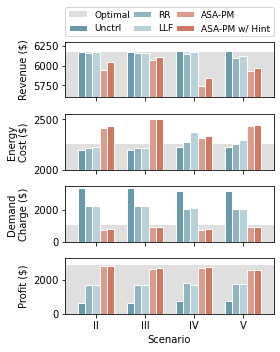

In [91]:
bar_width = 0.75
order = ['Unctrl', 'RR', 'LLF', 'ASA-PM', 'ASA-PM w/ Hint']
fig, ax = plt.subplots(4, 1, figsize=(4, 5), sharex=True)
pt = df.pivot(index='scenario', columns='alg')

# Revenue
pt['revenue'][order].loc[scenarios].plot.bar(ax=ax[0], linewidth=1, edgecolor='w', color=colors, width=bar_width, legend=False)
ax[0].fill_between([-1, 5], 0, pt['revenue']['Optimal']['I'], facecolor='grey', alpha=0.25,  label='Optimal')
lgd = ax[0].legend(bbox_to_anchor=(0., 1.1, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0., fontsize=9)
ax[0].set_ylim(5600, 6300)
ax[0].set_ylabel('Revenue ($)')

# Energy Cost
pt['energy_cost'][order].loc[scenarios].plot.bar(ax=ax[1], linewidth=1, edgecolor='w', color=colors, width=bar_width, legend=False)
ax[1].fill_between([-1, 5], 0, pt['energy_cost']['Optimal']['I'], facecolor='grey', alpha=0.25)
ax[1].set_ylim(2000, 2550)
ax[1].set_ylabel('Energy\nCost ($)')

# Demand Charge
pt['demand_charge'][order].loc[scenarios].plot.bar(ax=ax[2], linewidth=1, edgecolor='w', color=colors, width=bar_width, legend=False)
ax[2].fill_between([-1, 5], 0, pt['demand_charge']['Optimal']['I'], facecolor='grey', alpha=0.25)
ax[2].set_ylim(0, 3500)
ax[2].set_ylabel('Demand\nCharge ($)')

# Profit
pt['profit'][order].loc[scenarios].plot.bar(ax=ax[3], linewidth=1, edgecolor='w', color=colors, width=bar_width, legend=False)
ax[3].fill_between([-1, 5], 0, pt['profit']['Optimal']['I'], facecolor='grey', alpha=0.25, label='Optimal')
ax[3].set_ylim(0, 3250)
ax[3].set_ylabel('Profit ($)')

plt.xticks(rotation=0)
ax[3].set_xlabel('Scenario')
plt.tight_layout()

In [ ]:
fig.savefig('figures/profit_maximization.pdf', dpi=150)

#### Percentage of Optimal Profit

In [23]:
pt['profit'] /pt['profit']['Optimal']['I']

alg,ASA-PM,ASA-PM w/ Hint,LLF,Optimal,RR,Unctrl
scenario,,,,,,
I,NaN,NaN,NaN,1.0,NaN,NaN
II,0.965046,0.981487,0.583125,NaN,0.580576,0.213395
III,0.915435,0.924816,0.588585,NaN,0.578377,0.213395
IV,0.929024,0.945294,0.584908,NaN,0.620419,0.264392
V,0.886868,0.898498,0.613195,NaN,0.609384,0.264392
